<center><img src="../reports/figures/banner.jpg"></center>

<center><h1>Análisis de sentimientos de las elecciones a la Asamblea de Madrid 2021</h1></center>



## Índice

* [Introducción](#1)
* [⬇️ Extracción de Tweets](#2)
* [🧹 Limpieza de datos](#3)
* [📃 Procesamiento del texto](#4)
* [😁🤬 Análisis de sentimientos](#5)

<a id="1"></a>
## Introducción

El pasado martes 4 de mayo se celebraban las elecciones a la Asamblea de Madrid 2021. Estas elecciones son de alguna forma excepcionales y polémicas desde el mismo instante de su convocatoria. Esto se debe a la pandemia y a la polarización política de los últimos años en España. Así pues, se han saldado con la victoria de los partidos derecha y la derrota de la izquierda, obligando a dos de los principales candidatos a abandonar la política. También hemos asistido a la desaparición del partido Ciudadanos de la Asamblea, empeorando aún más su crisis como partido.

Por si fuera poco, la campaña electoral se desarrolló bajo un clima de mucha tensión, ya que algunos políticos del país recibieron sobres con balas. En las redes sociales, esta polarización se manifiesta más. Es frecuente ver insultos y descalificaciones en la mayoría de los mensajes.

Las elecciones de Madrid pueden afectar de alguna forma a elecciones futuras. Por tanto, es interesante analizar los sentimientos de los usuarios en redes —en este caso Twitter— con el objetivo de ver cómo se desarrolla esta polarización en todo el país.

### 🟢 Objetivo:

> Realizar un análisis de sentimientos en Twitter para ver el desarrollo de la polarización en España.

### 📚 Librerías

Para conseguir nuestro objetivo, necesitamos las siguientes librerías:

* **Tweepy**: la usaremos para descargar los tweets utilizando la API de Twitter.
* **Pandas**: librería para gestionar los datos.
* **NLTK**: es un conjunto de bibliotecas para realizar procesamiento del lenguaje natural.
* **sentiment-spanish**: paquete con el modelo para el análisis de sentimientos. Este paquete ha sido creado por @HugoJBello y se puede encontrar en este [repositorio](https://github.com/sentiment-analysis-spanish/sentiment-spanish)

In [32]:
import random
from collections import Counter
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from emoji.unicode_codes.es import EMOJI_UNICODE_SPANISH
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
from PIL import Image
from sentiment_analysis_spanish import sentiment_analysis
from wordcloud import WordCloud

# Tienes que descargarte las stopwords primero usando nltk.download()

<a id="2"></a>

## ⬇️ Extracción de tweets

Para descargar los *tweets* es necesario utilizar la API de Twitter. Esta API permite descargar todo tipo de información, desde nuestro propio perfil hasta datos de tendencias. La información que descargamos se puede personalizar utilizando las distintas funciones de la librería `tweepy`.

Para usar la API hay que registrarse en la página de desarrolladores [](https://developer.twitter.com/) y crear una app. En el formulario nos pedirán información básica como el nombre, descripción y el uso que se le va a dar. Esto último se hace para evitar usos maliciosos de la API 😈.

Una vez creada la app, se generarán los *tokens* para identificar nuestra cuenta. Es **muy importante** que guardes estos tokens en un lugar seguro, ya que solo se generarán una vez. Si los pierdes, tendrás que volver a generarlos. En este proyecto, se ha creado un archivo en la ruta `src/data/credentials.py` (no disponible en GitHub) que contiene los *tokens*. El contenido del fichero sigue la siguiente estructura:

```python

# Twitter App access keys for @user

# Consume:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

# Access:
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
```

El fichero `src/data/twitter_scraper.py` contiene las líneas de código necesarias para comunicarse con la API y descargarse los tweets.

```python
import credentials as cr

def setup():
    """
    Setup the Twitter's API with the keys provided in credentials.py
    """

    # Authentication
    auth = tw.OAuthHandler(cr.CONSUMER_KEY, cr.CONSUMER_SECRET)
    auth.set_access_token(cr.ACCESS_TOKEN, cr.ACCESS_TOKEN_SECRET)

    api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api


def search_topic(api, topic, items, date_from=None, date_to=None):
    # Collect tweets
    tweets = tw.Cursor(
        api.search_30_day,
        environment_name="dev",
        query=topic,
        fromDate=date_from,
        toDate=date_to,
    ).items(items)

    return tweets
```

La función `setup` configura e inicializa la API con las credenciales. Esta función devuelve la API configurada y lista para usarse. Finalmente, la función `search_topic` utiliza el método `Cursor` de Tweepy para evitar que la API nos devuelva los datos de una sola página. Para este proyecto, se ha usado la API premium `search_30_day`, que permite buscar los tweets en el último mes. Para usar esta API hay que crear un entorno de desarrollo en la página de desarrolladores de Twitter.

<a id="3"></a>

## 🧹 Limpieza de datos

Una vez extraídos los tweets en un archivo CSV, el siguiente paso consiste en eliminar aquellos datos que no son importantes para el análisis. Para ello, vamos a usar la librería `Pandas`, que nos permitirá gestionar los tweets en tablas llamadas *Dataframes*.

In [33]:
# Importamos los datos a un Dataframe
data = pd.read_csv("../data/raw/data.csv", index_col="ID")

data.head()

,Tweets,len,Date,Source,Likes,RTs
ID,,,,,,
1389716466304491522,"RT @vox_es: ‼ @Santi_ABASCAL ""Son unos buenos ...",139,2021-05-04 22:59:59,Twitter for iPhone,0,0
1389716466195472388,RT @mtgarcia82: Que gane el PP en un barrio ob...,140,2021-05-04 22:59:59,Twitter for Android,0,0
1389716465390080002,"RT @elsitacabello: Ahora sí, lo puedo decir, m...",100,2021-05-04 22:59:59,Twitter for Android,0,0
1389716465205583877,RT @YTanRicamente: Esta casa apoya a @Yolanda_...,140,2021-05-04 22:59:59,Twitter Web App,0,0
1389716462936412164,RT @Juanmi_News: Qué asco tener que ver que lo...,138,2021-05-04 22:59:59,Twitter for Android,0,0


A continuación, vamos a hacer un análisis exploratorio para ver los datos que disponemos. Comprobaremos también si tenemos datos nulos y duplicados.

In [34]:
# Mostramos las filas y columnas del dataframe
data.shape

(1000, 6)

In [35]:
# Comprobamos valores nulos
data.isna().any()

Tweets    False
len       False
Date      False
Source    False
Likes     False
RTs       False
dtype: bool

In [36]:
# Eliminar la cadena 'RT' en los tweets para quedarnos con la información relevante
data["Tweets"] = data["Tweets"].str.replace(
    r"RT.*:",
    "",
    regex=True,
)

In [37]:
# Eliminar saltos de línea y retorno para tenerlo todo en una frase
data["Tweets"] = data["Tweets"].str.replace("\n", "")
data["Tweets"] = data["Tweets"].str.replace("\r", "")

In [38]:
# Eliminar etiqueta #Elecciones4M
data["Tweets"] = data["Tweets"].str.replace("#Elecciones4M", "")

In [39]:
# Eliminar links
links_index = data[data["Tweets"].str.contains(r"//t\.co.*", regex=True)].index
data = data.drop(links_index)

Seguimos haciendo limpieza de los datos, eliminando información que no es relevante para el análisis.

In [40]:
# Seguimos eliminando links
links_index = data[data["Tweets"].str.contains("//t.c…")].index
data = data.drop(links_index)
data.shape

(696, 6)

In [41]:
# Eliminamos filas con ruido
data = data.drop(
    [
        1389714946599137283,
        1389714670081265669,
        1389714532499697667,
        1389715033786040322,
        1389714949367336965,
        1389714934095880192,
        1389714915737448451,
        1389714894241554438,
        1389714495413555202,
        1389715170969231361,
        1389715027356266502,
    ]
)

In [42]:
# Eliminar duplicados
data = data.drop_duplicates(subset=["Tweets"])

In [43]:
# Exportamos los datos preparados
data.to_csv("../data/processed/data_prepared.csv")

<a id="4"></a>

## 📃 Procesamiento del texto

Después de limpiar los datos, tenemos que hacer el procesamiento del texto. En este apartado lo que haremos será terminar de limpiar aquellas palabras y caracteres que no son útiles como:

* **Stop words**: las *stop words* son palabras muy frecuentes pero su valor sintáctico es escaso. Dentro de estas palabras encontramos preposiciones y artículos del castellano.
* Signos de puntuación.
* Emojis.

In [44]:
spanish_stopwords = stopwords.words("spanish")

# Eliminamos signos puntuación, números y emojis
emoji_list = list(EMOJI_UNICODE_SPANISH.values())

non_words = list(punctuation)
non_words.extend(["¿", "?", "…", "", "“", "«" "»", "•", "¡", "”"])
non_words.extend(map(str, range(10)))
emoji_list.extend(["🗳️", "🗣️", "🗳", "➡️"])
non_words.extend(emoji_list)

El siguiente paso consiste en tokenizar las palabras. Este proceso consiste en separar las palabras de una frase y tratarlas individualmente. De esta forma, podemos usar los tokens para entrenar al modelo y calcular la frecuencia de las palabras.

In [45]:
# Tokenizamos todas las palabras

tweets_text = data["Tweets"]
tweets_text = tweets_text.apply(word_tokenize)

tweets_text = tweets_text.to_list()
tweets_text = [j for i in tweets_text for j in i]

In [46]:
# Función para eliminar signos de puntuación y emojis


def drop_nonwords(tokens, non_words):
    tk_nonwords = []

    for word in tokens:
        text = "".join([letter for letter in word if letter not in non_words])
        if text != "":
            tk_nonwords.append(text.lower())

    return tk_nonwords


tweets_text = drop_nonwords(tweets_text, non_words)

# Eliminamos las stopwords
tweets_text = [word for word in tweets_text if word not in spanish_stopwords]

In [47]:
# Calculamos la frecuencia de palabras
frecuency = FreqDist(tweets_text)
print(frecuency.most_common(100))

[('madrid', 73), ('iglesias', 22), ('españa', 20), ('pablo', 19), ('pp', 18), ('elecciones', 18), ('hoy', 17), ('ayuso', 17), ('libertad', 16), ('podemos', 13), ('vox', 12), ('día', 12), ('pabloiglesias', 11), ('si', 10), ('directo', 10), ('izquierda', 9), ('sido', 9), ('política', 9), ('tras', 9), ('comunidad', 9), ('votar', 9), ('idiazayuso', 9), ('así', 8), ('eleccionesmadrid', 8), ('ser', 8), ('va', 8), ('madrileños', 8), ('ahora', 7), ('gran', 7), ('resultados', 6), ('decir', 6), ('toda', 6), ('comunismo', 6), ('gobierno', 6), ('cada', 6), ('the', 6), ('psoe', 6), ('gana', 6), ('️', 6), ('ver', 5), ('victoria', 5), ('gracias', 5), ('conseguido', 5), ('s', 5), ('verdad', 5), ('q', 5), ('‼', 4), ('buenos', 4), ('tener', 4), ('derecha', 4), ('fascismo', 4), ('escrutinio', 4), ('puede', 4), ('ciudadanos', 4), ('partido', 4), ('deja', 4), ('votado', 4), ('génova', 4), ('cómo', 4), ('eleccion', 4), ('abandona', 4), ('balcón', 4), ('discurso', 4), ('tan', 4), ('mejor', 4), ('electoral', 

Hemos visto que con `FreqDist` podemos saber la frecuencia de apariciones de una palabra. Para mejorar la visualización, crearemos una nube de palabras usando el logotipo de Twitter.

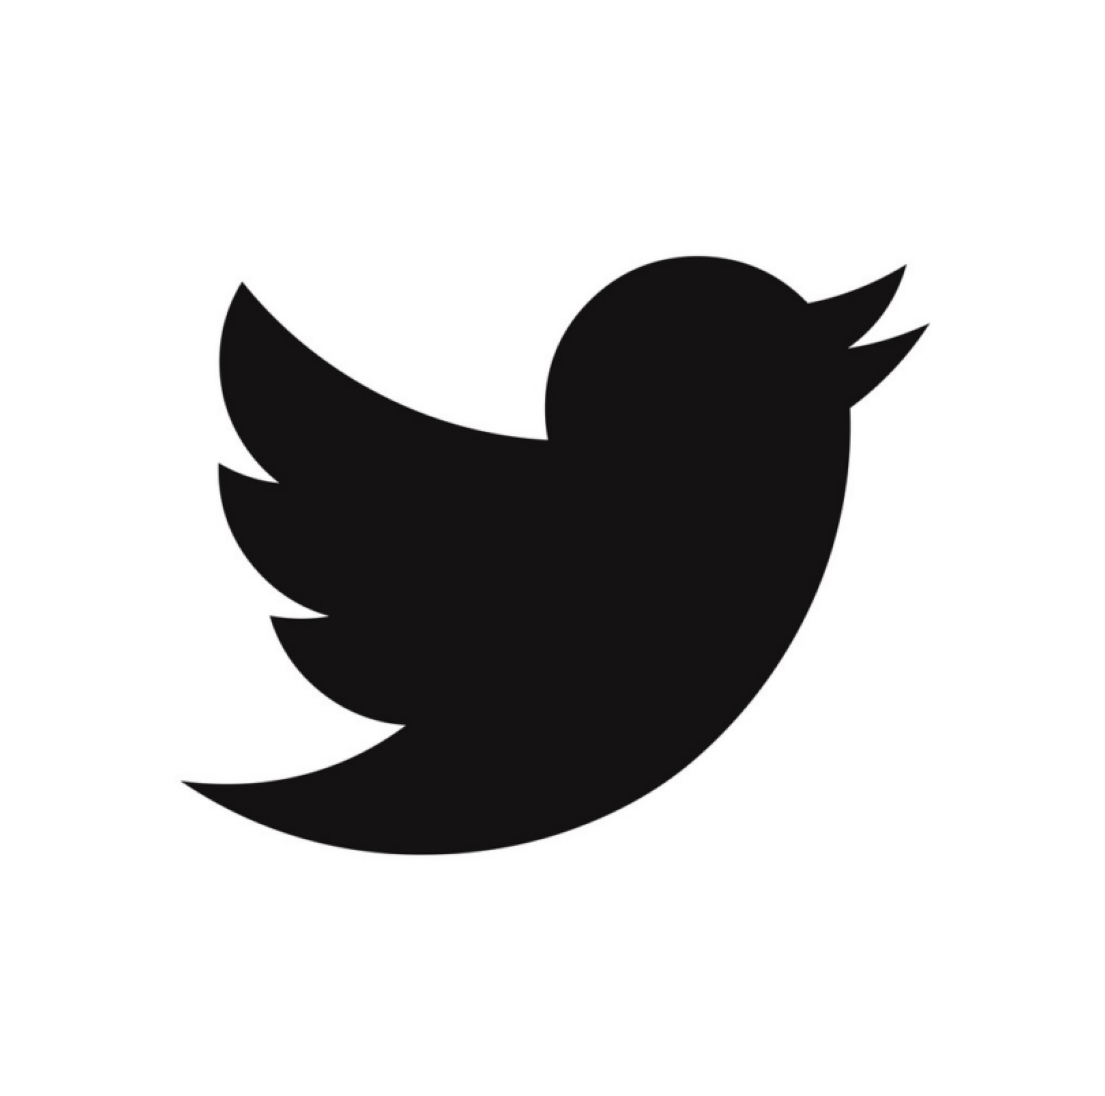

In [48]:
# Importamos la imagen del logo de Twitter
twitter_logo = np.array(Image.open("../reports/figures/twitter_logo.png"))

figure = plt.figure()
figure.set_figwidth(14)
figure.set_figheight(18)

plt.imshow(twitter_logo)
plt.axis("off")
plt.show()

In [49]:
# Función para generar el color azul de la nube de tweets
def blue_color(
    word,
    font_size,
    position,
    orientation,
    ramdom_state=None,
    **kwargs,
):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

In [50]:
tweets_long_string = tweets_text
tweets_long_string = " ".join(tweets_long_string)

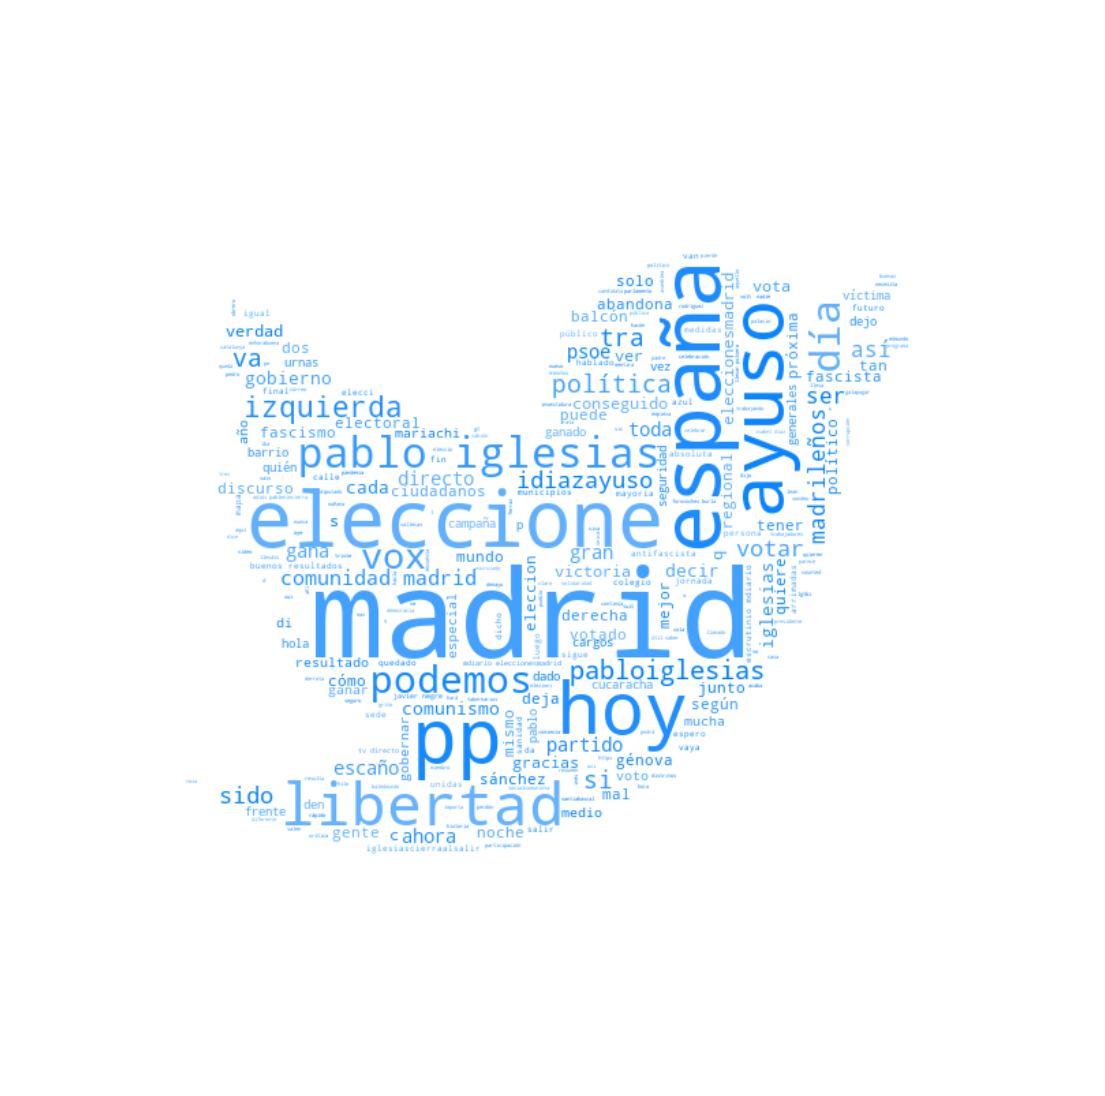

In [51]:
twitter_wc = WordCloud(
    background_color="white",
    max_words=1500,
    mask=twitter_logo,
)

# Generamos la nube de palabras
twitter_wc.generate(tweets_long_string)

# Mostramos por pantalla la nube de palabras
figure = plt.figure()
figure.set_figwidth(14)
figure.set_figheight(18)

plt.imshow(
    twitter_wc.recolor(color_func=blue_color, random_state=3),
    interpolation="bilinear",
)
plt.axis("off")
plt.show()

Entre las palabras más frecuentes destacamos `madrid`, `elecciones`,`ayuso`, `pablo iglesias`, `libertad`. Este es un comportamiento normal, puesto que casi todos los tweets obtenidos son posteriores al recuento de votos. En esos momentos, la candidata del PP, Isabel Díaz Ayuso, ganaba las elecciones y el candidato de Unidas Podemos, Pablo Iglesias, anunciaba su retirada de la política. La palabra `libertad` forma parte del lema de campaña 'Comunismo o libertad', usado por el PP. Otras palabras que tienen menos fuerza son `vox` y `psoe`. Estos dos partidos también han sido afectados por los resultados. En el caso de VOX, puede pactar con el PP para formar gobierno, y el PSOE pierde su puesto como líder de los partidos de izquierda a favor de Más Madrid. Por otro lado, también se pueden apreciar los típicos insultos que solemos ver en las campañas electorales como `fascista` o `cucaracha`.

<a id="5"></a>

## 😁🤬 Análisis de sentimientos

Para hacer el análisis de sentimientos, vamos a usar un modelo preentrenado de la librería `sentiment-spanish`. Esta librería utiliza un clasificador Naive Bayes para el modelo. El modelo ha sido entrenado con 800k reseñas de usuarios de las páginas eltenedor, decathlon, tripadvisor, filmaffinity y ebay. La salida del modelo da valores de probabilidad entre 0 y 1:

* 0 si la opinión es **muy negativa**.
* 0.5 si es neutral.
* 1 si la opinión es fantástica.

In [52]:
# Añadimos nueva columna al DataFrame con los valores de probabilidad

sentiment = sentiment_analysis.SentimentAnalysisSpanish()
data["sentiment_probability"] = data["Tweets"].apply(sentiment.sentiment)

data.head()

C:\Users\ajf97\anaconda3\envs\twitter\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\ajf97\anaconda3\envs\twitter\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,Tweets,len,Date,Source,Likes,RTs,sentiment_probability
ID,,,,,,,
1389716466304491522,"‼ @Santi_ABASCAL ""Son unos buenos resultados ...",139,2021-05-04 22:59:59,Twitter for iPhone,0,0,0.389508
1389716466195472388,Que gane el PP en un barrio obrero y pendient...,140,2021-05-04 22:59:59,Twitter for Android,0,0,0.077509
1389716465390080002,"Ahora sí, lo puedo decir, meteros los aplauso...",100,2021-05-04 22:59:59,Twitter for Android,0,0,0.006106
1389716465205583877,"Esta casa apoya a @Yolanda_Diaz_, encargada d...",140,2021-05-04 22:59:59,Twitter Web App,0,0,0.028639
1389716462936412164,Qué asco tener que ver que los que pisotean e...,138,2021-05-04 22:59:59,Twitter for Android,0,0,0.000111


Al mostrar solo las 5 primeras filas del dataframe, podemos ver que las opiniones son muy negativas. Y no es para menos, porque si vemos los mensajes, nos encontramos a gente que se queja de la victoria del PP en un barrio obrero, otro que tiene mucho asco y un usuario encantador que manda a otra gente a meterse los aplausos por zonas delicadas del cuerpo humano 😂.

In [53]:
def probability_labeler(probability):
    if probability > 0.5:
        return "Positive"
    elif probability == 0.5:
        return "Neutral"
    elif probability < 0.5:
        return "Negative"


# Añadimos otra columna con la etiqueta de los sentimientos

data["sentiment"] = data["sentiment_probability"].apply(probability_labeler)

data.head()

,Tweets,len,Date,Source,Likes,RTs,sentiment_probability,sentiment
ID,,,,,,,,
1389716466304491522,"‼ @Santi_ABASCAL ""Son unos buenos resultados ...",139,2021-05-04 22:59:59,Twitter for iPhone,0,0,0.389508,Negative
1389716466195472388,Que gane el PP en un barrio obrero y pendient...,140,2021-05-04 22:59:59,Twitter for Android,0,0,0.077509,Negative
1389716465390080002,"Ahora sí, lo puedo decir, meteros los aplauso...",100,2021-05-04 22:59:59,Twitter for Android,0,0,0.006106,Negative
1389716465205583877,"Esta casa apoya a @Yolanda_Diaz_, encargada d...",140,2021-05-04 22:59:59,Twitter Web App,0,0,0.028639,Negative
1389716462936412164,Qué asco tener que ver que los que pisotean e...,138,2021-05-04 22:59:59,Twitter for Android,0,0,0.000111,Negative


In [54]:
print(Counter(data["sentiment"].to_list()))

Counter({'Negative': 163, 'Positive': 65})


In [55]:
# Creamos un nuevo dataframe para el gráfico de barras

bar_chart = (
    data["sentiment"]
    .value_counts()
    .rename_axis("Sentiment")
    .to_frame("Total Tweets")
    .reset_index()
)

bar_chart

,Sentiment,Total Tweets
0,Negative,163
1,Positive,65


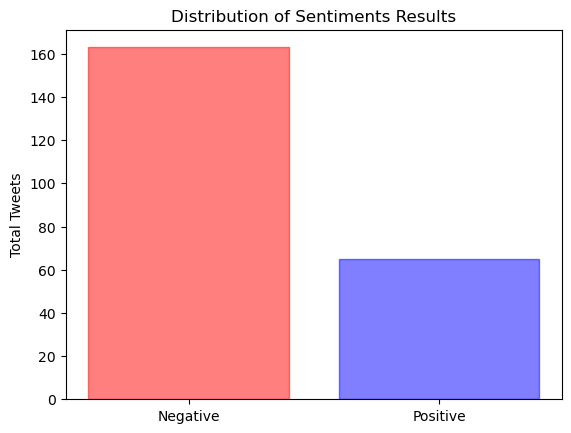

In [56]:

# Mostramos el gráfico de barras

bar = plt.bar(
    bar_chart["Sentiment"],
    bar_chart["Total Tweets"],
    align="center",
    alpha=0.5,
)

bar[0].set_color("r")
bar[1].set_color("b")

plt.ylabel("Total Tweets")
plt.title("Distribution of Sentiments Results")
plt.show()

Si hacemos un gráfico de barras, podemos ver que la mayoría de las opiniones expresadas en Twitter son negativas. Este es un comportamiento muy frecuente en los últimos años, donde la polarizacion política ha ido en aumento. Por último, vamos a ver algunos ejemplos más de tweets publicados.

In [57]:
data[
    [
        "Tweets",
        "sentiment",
        "sentiment_probability",
    ]
].sample(20, random_state=60)

,Tweets,sentiment,sentiment_probability
ID,,,
1389715184638439436,📡 Sigue en directo en @COPE el Especial 🗳 en...,Positive,6.068826e-01
1389716415545028613,"Lo de ""Comunismo o Libertad"", con libertad ¿a...",Negative,4.375009e-03
1389716118445740035,"""El trumpismo a la madrileña de Ayuso se cons...",Positive,9.921169e-01
1389716394904899585,#EleccionesMadridA3N | Abascal ha ratificado ...,Negative,1.260415e-03
1389715736445296645,"Para gobernar te uniste a separatistas, terro...",Negative,3.262795e-03
1389715768951164928,"""Pocos se podían imaginar en estos siete años...",Negative,2.445757e-04
1389716058580336644,"Iglesias se va, el PSOE se hunde y Ciudadanos...",Negative,5.989531e-02
1389716174976528393,¿Querían guerra? Toma guerra.Ayuso gana en Pi...,Negative,3.985160e-01
1389716466304491522,"‼ @Santi_ABASCAL ""Son unos buenos resultados ...",Negative,3.895078e-01


Vemos como el modelo clasifica los sentimientos correctamente en la mayoría de casos. Sin embargo, también existen falsos negativos y positivos. Por ejemplo, vemos la fila con ID 1389714191007854593 donde el tweet pertenece claramente a un periódico. El contenido del mensaje indica la posible victoria de Ayuso, y ha sido marcado como negativo en lugar de neutral. También vemos el tweet 1389714307588440066, que ha sido etiquetado como positivo en lugar de negativo, ya que el usuario no ha aceptado el resultado.